Check NA stuff


This script "attempts" to match entries if their authors intesect (not sure how well it's doing that or if it is even reasonable)

In [2]:
import pandas as pd
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt
from cProfile import label #?not sure
import re

In [3]:
#removing space after authors 
def fix_author(row):
    if not isinstance(row, str) or row[-1] != ' ':
        return row
    return row[:-1]

In [4]:
#This is path to output csv files of the index of each book with they italicized names filtered out
vol1_path = '../input/index_without_itallics_csvs/vol1/vol1_index_pruned.csv'
vol2_path = '../input/index_without_itallics_csvs/vol2/vol2_index_pruned.csv'
vol3_path = '../input/index_without_itallics_csvs/vol3/vol3_index_pruned.csv'

vol1_df = pd.read_csv(vol1_path)
vol2_df = pd.read_csv(vol2_path)
vol3_df = pd.read_csv(vol3_path)

#fix spacing issue
vol1_df['author'] = vol1_df['author'].apply(fix_author)
vol2_df['author'] = vol2_df['author'].apply(fix_author)
vol3_df['author'] = vol3_df['author'].apply(fix_author)

#changing name of columns 
vol1_df.rename(columns={'genus': 'mouterde_genus', 'epithet': 'mouterde_epithet', 'author':'mouterde_author', 'infra':'mouterde_infra'}, inplace=True)
vol2_df.rename(columns={'genus': 'mouterde_genus', 'epithet': 'mouterde_epithet', 'author':'mouterde_author', 'infra':'mouterde_infra'}, inplace=True)
vol3_df.rename(columns={'genus': 'mouterde_genus', 'epithet': 'mouterde_epithet', 'author':'mouterde_author', 'infra':'mouterde_infra'}, inplace=True)

#wcvp 
text_wcvp_path = '../input/wcvp/wcvp_v9_jun_2022.txt'
wcvp_df = pd.read_csv(text_wcvp_path, sep = '|')

In [5]:
def get_set(x):
    if not isinstance(x, list): #is this the best way
        x = []
    return set(x)

#to use after exploding the authors
connectors = {'ex', '&'}
def remove_prantheses(x):
    if isinstance(x, str):
        return re.sub(r'([()])', '', x)
    return x

In [6]:
def process_wcvp(wcvp_df):
    wcvp_df['infraspecies'].replace(np.nan, 'np.NaN', inplace=True)
    wcvp_df['species'].replace(np.nan, 'np.NaN', inplace=True)
    wcvp_df['authors_set'] = wcvp_df['authors'].str.split(' ').apply(lambda x : get_set(x) - connectors)
    wcvp_df_explode = wcvp_df.explode('authors_set')
    wcvp_df_explode['authors_set'] = wcvp_df_explode['authors_set'].apply(remove_prantheses) #to remove prantheses
    return wcvp_df_explode

In [7]:
def get_overlapping_authors(mouterde_df, wcvp_df_explode):
    mouterde_df['mouterde_infra'].replace(np.nan, 'np.NaN', inplace=True)
    mouterde_df['mouterde_epithet'].replace(np.nan, 'np.NaN', inplace=True)
    mouterde_df['mouterde_author'] = mouterde_df['mouterde_author'].str.replace(' et ', ' & ')

    mouterde_df['authors_set'] = mouterde_df['mouterde_author'].str.split(' ').apply(lambda x : get_set(x) - connectors)
    mouterde_df_explode = mouterde_df.explode('authors_set')
    mouterde_df_explode['authors_set'] = mouterde_df_explode['authors_set'].apply(remove_prantheses) #to remove prantheses

    # had duplicates 
    merge_df = pd.merge(mouterde_df_explode, 
                        wcvp_df_explode, 
                        how='inner', 
                        left_on=['mouterde_genus','mouterde_epithet', 'mouterde_infra' , 'authors_set'], 
                        right_on = ['genus','species', 'infraspecies', 'authors_set'])

    merge_df_simplified = merge_df[['mouterde_genus', 'mouterde_epithet', 'mouterde_infra', 'mouterde_author', 'authors', 'taxonomic_status', 'accepted_name', 'accepted_authors']]
    return merge_df_simplified.drop_duplicates()

In [8]:
def get_miss_match(mouterde_df, merge_df):
    
    merge_df2 = pd.merge(mouterde_df, 
                         merge_df, 
                         how='left', 
                         left_on=['mouterde_genus','mouterde_epithet', 'mouterde_infra' , 'mouterde_author'], 
                         right_on = ['mouterde_genus','mouterde_epithet', 'mouterde_infra', 'mouterde_author'])

    merge_df2 = merge_df2[merge_df2['taxonomic_status'].isna()]

    merge_df2_simplified = merge_df2[['mouterde_genus', 'mouterde_epithet', 'mouterde_infra', 'mouterde_author', 'authors', 'taxonomic_status', 'accepted_name', 'accepted_authors']]
    return merge_df2_simplified

In [9]:
wcvp_df_explode = process_wcvp(wcvp_df)
vol1_wcvp_df_simplified = get_overlapping_authors(vol1_df, wcvp_df_explode)
vol2_wcvp_df_simplified = get_overlapping_authors(vol2_df, wcvp_df_explode)
vol3_wcvp_df_simplified = get_overlapping_authors(vol3_df, wcvp_df_explode)

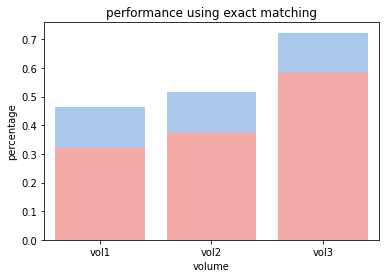

In [10]:
pick_up_rates = [vol1_wcvp_df_simplified.shape[0]/vol1_df.shape[0],
                 vol2_wcvp_df_simplified.shape[0]/vol2_df.shape[0],
                 vol3_wcvp_df_simplified.shape[0]/vol3_df.shape[0]]
accepted_rate = [(vol1_wcvp_df_simplified['taxonomic_status'] == 'Accepted').sum()/vol1_df.shape[0],
                 (vol2_wcvp_df_simplified['taxonomic_status'] == 'Accepted').sum()/vol2_df.shape[0],
                 (vol3_wcvp_df_simplified['taxonomic_status'] == 'Accepted').sum()/vol3_df.shape[0]]

ax = plt.subplots()

pastel_blue = sns.color_palette("pastel")[0]
pastel_red = sns.color_palette("pastel")[3]

ax = sns.barplot(x=['vol1', 'vol2', 'vol3'], y=pick_up_rates, color=pastel_blue, label = 'percentage picked up')
ax = sns.barplot(x=['vol1', 'vol2', 'vol3'], y=accepted_rate, color=pastel_red, label = 'percentage accepted')

ax.set(xlabel="volume", ylabel="percentage", title = "performance using exact matching")

#plt.legend()
plt.show()

In [11]:
pick_up_rates

[0.46359048305695744, 0.5146958304853042, 0.7231812577065352]

In [12]:
vol1_wcvp_missed_df_simplified = get_miss_match(vol1_df, vol1_wcvp_df_simplified)
vol2_wcvp_missed_df_simplified = get_miss_match(vol2_df, vol2_wcvp_df_simplified)
vol3_wcvp_missed_df_simplified = get_miss_match(vol3_df, vol3_wcvp_df_simplified)

In [13]:
vol1_wcvp_missed_df_simplified

,mouterde_genus,mouterde_epithet,mouterde_infra,mouterde_author,authors,taxonomic_status,accepted_name,accepted_authors
0,Acanthophyllum,np.NaN,np.NaN,NaN,NaN,NaN,NaN,NaN
2,Achyranthes,np.NaN,np.NaN,NaN,NaN,NaN,NaN,NaN
4,Adiantum,np.NaN,np.NaN,NaN,NaN,NaN,NaN,NaN
6,Aegilops,np.NaN,np.NaN,NaN,NaN,NaN,NaN,NaN
12,Aegilops,juvenali∫,np.NaN,Thell.,NaN,NaN,NaN,NaN
...,...,...,...,...,...,...,...,...
1375,Viscum,cruciatum,np.NaN,Sieb.,NaN,NaN,NaN,NaN
1376,Vulpia,np.NaN,np.NaN,NaN,NaN,NaN,NaN,NaN
1377,Vulpia,ciliata,np.NaN,(Pers.) Link,NaN,NaN,NaN,NaN
1384,Zannichellia,np.NaN,np.NaN,NaN,NaN,NaN,NaN,NaN


In [14]:
vol2_wcvp_missed_df_simplified

,mouterde_genus,mouterde_epithet,mouterde_infra,mouterde_author,authors,taxonomic_status,accepted_name,accepted_authors
0,Acacia,np.NaN,np.NaN,NaN,NaN,NaN,NaN,NaN
1,Acacia,albida,np.NaN,Del.,NaN,NaN,NaN,NaN
3,Acer,np.NaN,np.NaN,NaN,NaN,NaN,NaN,NaN
6,Acer,tauricolum,np.NaN,Boiss. & Bal.,NaN,NaN,NaN,NaN
7,Actinolema,np.NaN,np.NaN,NaN,NaN,NaN,NaN,NaN
...,...,...,...,...,...,...,...,...
1454,Ranunculus,macrorrhynchup,np.NaN,Boiss.-,NaN,NaN,NaN,NaN
1455,Ranunculus,marginaţus,np.NaN,d'Urv.,NaN,NaN,NaN,NaN
1460,Ranunculus,neapolitanus,np.NaN,Ten,NaN,NaN,NaN,NaN
1462,Ranunculus,orbiculatus,np.NaN,Boiss. & Bo.,NaN,NaN,NaN,NaN


In [15]:
vol3_wcvp_missed_df_simplified

,mouterde_genus,mouterde_epithet,mouterde_infra,mouterde_author,authors,taxonomic_status,accepted_name,accepted_authors
0,Acantholepis,np.NaN,np.NaN,Less.',NaN,NaN,NaN,NaN
4,Acantholimon,antilibanoticum,np.NaN,Mout.,NaN,NaN,NaN,NaN
15,Achillea,biebersteinii,np.NaN,Afan.,NaN,NaN,NaN,NaN
22,Achillea,wilhelmsii,np.NaN,C. Koch,NaN,NaN,NaN,NaN
26,Ajuga,chasmophila,np.NaN,Davis,NaN,NaN,NaN,NaN
...,...,...,...,...,...,...,...,...
1618,Xeranthemum,longipapposum,np.NaN,Fisch. & Mey.,NaN,NaN,NaN,NaN
1620,Ziziphora,'Abd-el-'asissi,np.NaN,Hand.-Mazz.,NaN,NaN,NaN,NaN
1621,Ziziphora,acutifolia,np.NaN,Montb. & Auch.,NaN,NaN,NaN,NaN
1624,Ziziphora,capitata,orientalis,Sam. ex Rech. fil.,NaN,NaN,NaN,NaN


In [16]:
# example of a weird situation
genus = "Ajuga"
species = "chasmophila"
wcvp_df[(wcvp_df['genus'] == genus) & (wcvp_df['species'] == species)]

# author = 'Davis'
# wcvp_df[(wcvp_df['authors'] == author)]

,kew_id,family,genus,species,infraspecies,taxon_name,authors,rank,taxonomic_status,accepted_kew_id,accepted_name,accepted_authors,parent_kew_id,parent_name,parent_authors,reviewed,publication,original_name_id,authors_set
639632,444548-1,Lamiaceae,Ajuga,chasmophila,np.NaN,Ajuga chasmophila,P.H.Davis,SPECIES,Accepted,NaN,NaN,NaN,20646-1,Ajuga,L.,Reviewed,Kew Bull. 2: 64 (1947),NaN,{P.H.Davis}


In [17]:
vol1_df

,page_num,mouterde_genus,mouterde_epithet,mouterde_infra,mouterde_author,taxon rank,authors_set
0,616,Acanthophyllum,np.NaN,np.NaN,NaN,genus,{}
1,616,Acanthophyllum,kurdicum,np.NaN,Boiss. & Hausskn.,species,"{Boiss., Hausskn.}"
2,616,Achyranthes,np.NaN,np.NaN,NaN,genus,{}
3,616,Achyranthes,aspera,np.NaN,L.,species,{L.}
4,616,Adiantum,np.NaN,np.NaN,NaN,genus,{}
...,...,...,...,...,...,...,...
1382,638,Vulpia,uniglumis,np.NaN,(Sol.) Dumort.,species,"{Dumort., (Sol.)}"
1383,638,Zannichellia,np.NaN,np.NaN,NaN,genus,{}
1384,638,Zannichellia,palustris,np.NaN,L.,species,{L.}
1385,638,Zostera,np.NaN,np.NaN,NaN,genus,{}
